In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from CNNLorenzMie.Localizer import Localizer

We want to use the YOLO Algorithm for detecting and localizing holograms on a video frame image. We've packaged the YOLO into a convenient and easy-to-use object model called **Localizer**. We can initialize the model like this:

In [23]:
loc = Localizer(configuration='holo')

INFO:darknet:Loading network and metadata
INFO:darknet:layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 

If it loaded correctly, we see the network's architecture, and it tells us that it loaded the weights file correctly.

Making detections with this model is easy. First, we upload the experimental data as a numpy array (opencv does this by default).

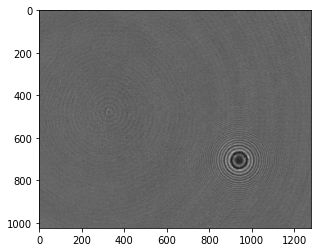

In [24]:
imgname = '../examples/test_image_large.png'
img = cv2.imread(imgname)
plt.imshow(img)

Now, we can input it into the Localizer model's predict() method. 
*Note: the Localizer expects a list of images as input, so we wrap our single image in a list.*

In [25]:
img_list = [img]
pred = loc.predict(img_list)
print(pred)

[[{'label': b'HOLO', 'conf': 0.599381685256958, 'bbox': (943.1991577148438, 703.5460205078125, 153.0026092529297, 148.02035522460938)}, {'label': b'HOLO', 'conf': 0.5468334555625916, 'bbox': (331.77569580078125, 478.1768798828125, 94.87818908691406, 94.1760482788086)}, {'label': b'HOLO', 'conf': 0.4329155683517456, 'bbox': (332.34613037109375, 477.818603515625, 152.01637268066406, 150.35659790039062)}, {'label': b'HOLO', 'conf': 0.341424822807312, 'bbox': (941.0361328125, 704.5556640625, 97.44854736328125, 94.56726837158203)}]]


Let's examine the output of predict(). pred is a list of lists of dictionaries. Each list of dictionaries corresponds to one image in our input list. For each image, the Localizer detects a certain number of features. Each feature is represented by a dictionary.

In [10]:
onefeature = pred[0][0]
print(onefeature)

{'label': b'HOLO', 'conf': 0.599381685256958, 'bbox': (943.1991577148438, 703.5460205078125, 153.0026092529297, 148.02035522460938)}


For each feature, we have a label (this will always be 'HOLO' in our case), a confidence percentage, and a bounding box. The bounding box has 4 numbers, they correspond to the $(x,y)$ position of the center of the feature, and the width and height of the bounding box.

In [12]:
x,y,w,h = onefeature['bbox']
print('Feature centered at ({},{}) with box size ({},{})'.format(x,y,w,h))

Feature centered at (943.1991577148438,703.5460205078125) with box size (153.0026092529297,148.02035522460938)


Putting this all together, we can view our Localizer's predictions overlaid onto the image:

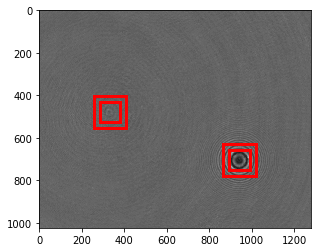

In [16]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for feature in pred[0]:
    x,y,w,h= feature['bbox']
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

As we can see, the Localizer is making false positive predictions. We can fix this in a number of ways.

First, we can change the detection **threshold** on the Localizer. This means that we require a greater level of confidence for the model to make a detection.

Number of predictions before: 4, number of predictions after: 2


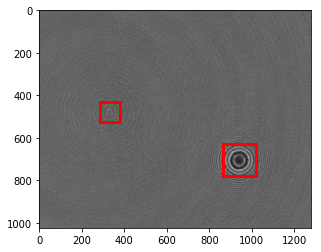

In [21]:
loc.threshold = 0.5
pred2 = loc.predict(img_list)
print('Number of predictions before: {}, number of predictions after: {}'.format(len(pred[0]), len(pred2[0])))

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for feature in pred2[0]:
    x,y,w,h= feature['bbox']
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

We can also invoke some of the filters we have available in the package. In this case, the **nodoubles** filter will be useful to us. We can just feed the output of predict() straight into the filter:

Number of predictions before: 4, number of predictions after: 2


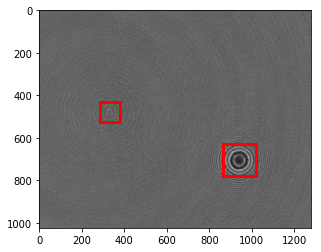

In [45]:
from CNNLorenzMie.nodoubles import nodoubles

#reset the threshold
loc.threshold = 0.3
pred = loc.predict(img_list)
before = len(pred[0])
#filter out double-predictions
pred = nodoubles(pred)
after = len(pred[0])
print('Number of predictions before: {}, number of predictions after: {}'.format(before, after))

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for feature in pred[0]:
    x,y,w,h= feature['bbox']
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

This is starting to look pretty good, but we still have one false positive left over. It's caused by the oil droplet on the objective lens, so we know it'll be there in every frame of our video, always in the same place. We can filter this one out by using **filter_artifact**.

(331.77569580078125, 478.1768798828125)


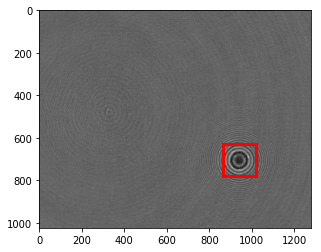

In [46]:
from CNNLorenzMie.filter_artifact import filter_artifact

#first, get the location of the artifact
artifact_pred = [x for x in pred[0] if x['bbox'][0]<500][0]
artifact_location = artifact_pred['bbox'][:2]
print(artifact_location)

#remove any predictions within 3 pixels distance from location of artifact
pred = filter_artifact(preds_list = pred, location = artifact_location, tol=3)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for feature in pred[0]:
    x,y,w,h= feature['bbox']
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)